# 바이크 수요 예측하기!

하지만 하루 중 어떤 시간대, 어떤 계절, 어떤 날씨에 사람들이 자전거를 얼마나 빌려 탈지 **정확히 예측하는 것**은 쉽지 않은 문제입니다.  

이 문제는 2011~2012년 워싱턴 D.C.의 실제 자전거 대여 데이터를 바탕으로,  
**날짜·시간·기상 정보** 같은 다양한 변수를 활용해 **자전거 대여 수요(`count`)**를 예측하는 머신러닝 회귀 문제입니다.  

👉 이 문제를 통해 우리는  
- **EDA**로 계절·날씨·시간대와 수요의 관계를 탐색하고,  
- **전처리와 피처 엔지니어링**으로 데이터 품질을 개선하며,  
- **여러 고전적 ML 모델**을 적용해 성능을 비교하는 과정을 경험할 수 있습니다.  

(통계 시간에 배웠던 회귀에서의 유의점 기억하시죠?)

### 오늘의 목표

1. MSE 손실함수값 3000 이하를 달성
2. RMSE 값 150 이하를 달성
3. 데이터 시각화 및 예측결과 시각화를 모두 진행하였다.

### 주요 변수와 자전거 대여 수요(`count`) 관계 시각화

모델의 귀납적 편향이 데이터셋과 일치하는지 확인하기 위해, 비선형적이거나 상호작용적인 패턴이 나타날 수 있는 주요 변수들과 타겟 변수(`count`) 간의 관계를 더 다양한 시각화 자료를 통해 탐색합니다.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 훈련 데이터 불러오기

데이터를 전처리 하기 이전에, 기초적인 데이터 모양새부터 확인해봅시다.

In [ ]:
train_df = pd.read_csv('./train.csv')

# 대략적인 모양 확인
train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [ ]:
# 공란이 있는지, 데이터형은 무엇인지, 크기는 총 얼마인지 여러 정보를 봐야겠죠?
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


# 연/월/일 데이터의 분리

계절 및 특정 시간대의 정보도 포함하기 위해 대여시각을 분리하는 것 또한 중요 요소!

In [ ]:
# datetime 컬럼을 datetime 자료형으로 변환
train_df['datetime'] = pd.to_datetime(train_df['datetime'])

# datetime 정보를 연, 월, 일, 시, 분, 초로 분리하여 새로운 열 생성
train_df['year'] = train_df['datetime'].dt.year
train_df['month'] = train_df['datetime'].dt.month
train_df['day'] = train_df['datetime'].dt.day
train_df['hour'] = train_df['datetime'].dt.hour
train_df['min'] = train_df['datetime'].dt.minute
train_df['sec'] = train_df['datetime'].dt.second

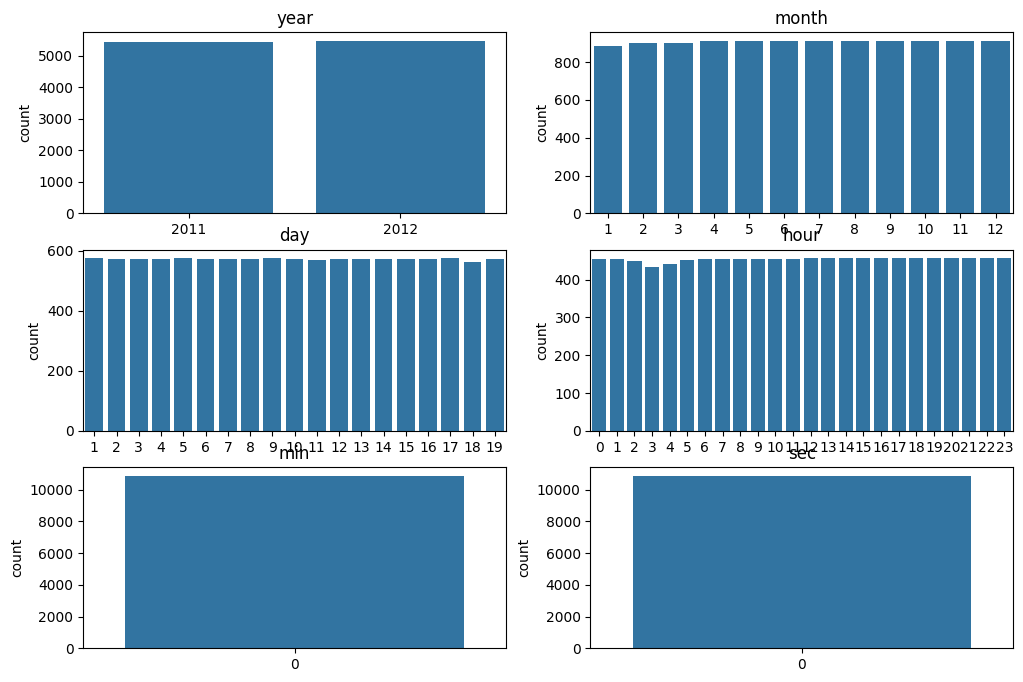

In [ ]:
# datetime 컬럼을 datetime 자료형으로 변환하고 연, 월, 일, 시, 분, 초까지 6가지 컬럼 생성하기
import seaborn as sns

plt.figure(figsize=(12,8))

plt.subplot(321)
sns.countplot(data=train_df, x='year').set_xlabel('')
plt.title('year')

plt.subplot(322)
sns.countplot(data=train_df, x='month').set_xlabel('')
plt.title('month')

plt.subplot(323)
sns.countplot(data=train_df, x='day').set_xlabel('')
plt.title('day')

plt.subplot(324)
sns.countplot(data=train_df, x='hour').set_xlabel('')
plt.title('hour')

plt.subplot(325)
sns.countplot(data=train_df, x='min').set_xlabel('')
plt.title('min')

plt.subplot(326)
sns.countplot(data=train_df, x='sec').set_xlabel('')
plt.title('sec')

plt.show()

### Q. 연/월/일 데이터를 분리하고 보니 어떤 점이 보이시나요?


<details>
<summary>A. 정답은~</summary>

분(min)과 초(sec)은 모든 데이터가 0으로, 시각은 '시(hour)' 단위에서 끊긴 것을 알 수 있습니다! 학습 시 이 데이터 열은 삭제하는 게 편하겠죠?
</details>

# 독립변수 간 상관관계를 분석하자!

기초통계 시간, 상관관계와 다중공선성(multicollinearity) 기억하시나요?

corr() 메서드는 변수 간 선형관계가 있는지 계산해주는 메서드로, +1이면 강한 양의 선형성을, -1이면 강한 음의 선형성을 알려줍니다.

만약 두 변수가 양극단의 상관관계 값을 갖는다면...? 다중공선성을 의심할 수 있겠죠!

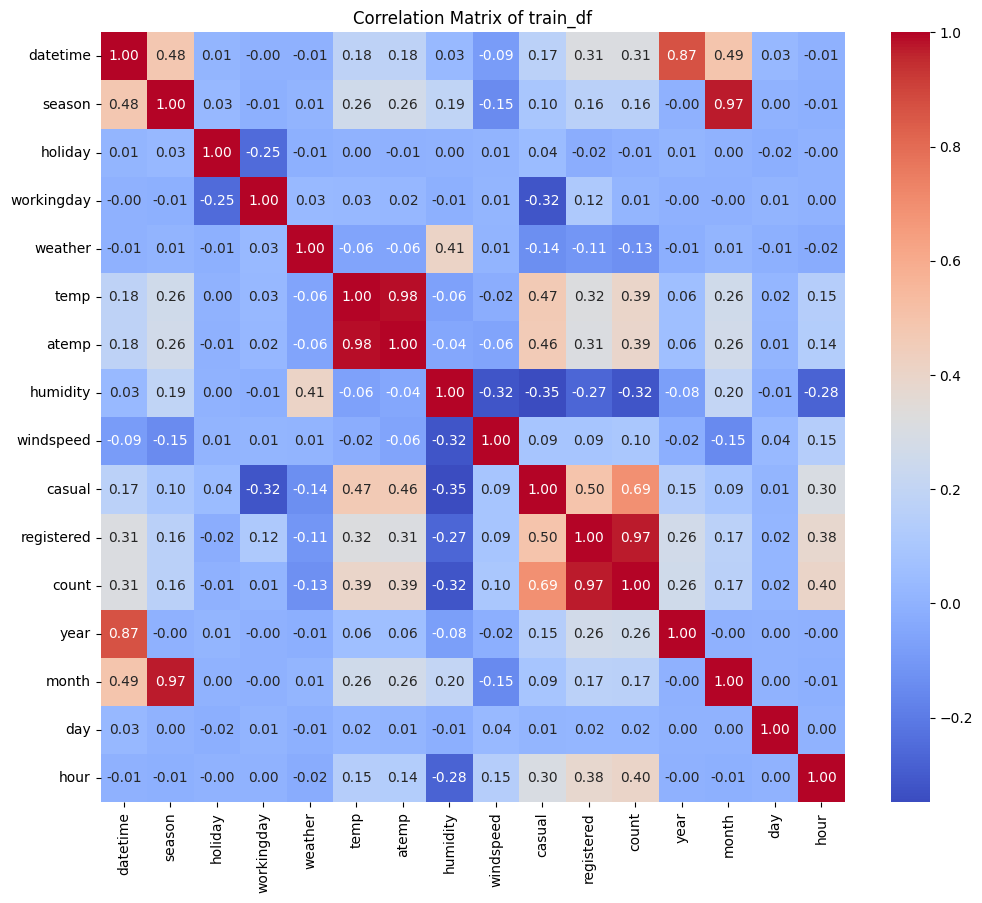

In [ ]:
plt.figure(figsize=(12, 10))

# 앞에서 확인했던 'min', 'sec' 칼럼은 상관계수 계산에서 제외해줍니다.
sns.heatmap(train_df.drop(['min', 'sec'], axis=1).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of train_df')
plt.show()

### VIF(Variance Inflation Factor) 계산하기

다중공선성을 계산하는 지표로 VIF가 있었습니다!

$\text{VIF} = \frac{1}{1-R^2}$으로, $R^2$ 값은 결정계수로 주어졌었죠.

이 때 결정계수는, 특정한 변수에 대해서 자기 자신을 제외한 나머지 변수들로 회귀를 돌려 얻습니다.

즉 VIF 값이 높다는 것은 자기 자신을 제외하고도 모델의 설명력이 충분히 확보된다는 뜻이므로, 다른 지표와 함께 해당 변수가 다른 변수와 강한 관계를 갖는다 (or 거의 사용되지 않는다)는 증거로 택할 수 있습니다.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_vif = train_df.drop(['min', 'sec'], axis=1)
numeric_cols = X_vif.select_dtypes(include=['int64', 'float64']).columns

# 각각의 피쳐에 대해서 VIF 계산
vif_data = pd.DataFrame()
vif_data["feature"] = numeric_cols
vif_data["VIF"] = [variance_inflation_factor(X_vif[numeric_cols].values, i) for i in range(X_vif[numeric_cols].shape[1])]

print("VIF values:")
display(vif_data)

VIF values:


/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,season,6.820092
1,holiday,1.094765
2,workingday,4.072190
3,weather,7.355967
4,temp,263.959086
5,atemp,292.306415
6,humidity,12.913588
7,windspeed,3.076292
8,casual,inf
9,registered,inf


### Q. 어떤 변수가 다중공선성을 갖고 있다고 판단할 수 있을까요?

<details>
<summary>A. 정답은~</summary>

'temp' 및 'atemp' 열이라고 판단할 수 있습니다!

1. corr 상관계수 행렬에서 거의 +1의 양의 값을 보임
2. VIF 값이 매우 높음

나아가서 'humidity' 열도 10 이상의 VIF 값을 갖는 것을 보아하니 다중공선성을 의심할 수 있겠네요!

또, casual, registered 열은 오늘 예측해야 할 count 열과 관계가 깊은 것을 보아하니 반드시 제거해야겠습니다.
</details>

# 회귀모델 돌리기!!!

이제 모델을 돌려볼 시간입니다! 과연 어떤 결과가 나올까요? 두구두구두구

회귀모델로는 먼저 간단히 선형회귀를 해보도록 합시다.

### A. 아무 변수도 제거하지 않으면 어떻게 될까요?

In [ ]:
from sklearn.model_selection import train_test_split

# 다중공선성을 확인했지만, 만약 변수 전처리를 하지 않으면 어떻게 되는지 봅시다.
# datetime 열은 분리를 했으니 그래도 제거해야겠죠?
# 또, 'casual', 'registered' 열은 타겟변수와 관계가 커 미리 제거합니다.
# 제거하지 않으면 무슨 일이 일어나는지 체크해보셔도 좋아요~
X = train_df.drop(['count', 'casual', 'registered', 'datetime'], axis=1)
y = train_df['count']


# 훈련 데이터와 테스트 데이터 분리
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

# 선형회귀 모델
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train,y_train)

y_pred = model.predict(X_test)

# MSE 및 RMSE 계산
from sklearn.metrics import mean_squared_error as mse
mse_error = mse(y_pred,y_test)
rmse_error = mse_error ** 0.5
print('mse error = ', mse_error)
print('rmse error = ', rmse_error)

mse error =  19945.37005375403
rmse error =  141.22807813517124


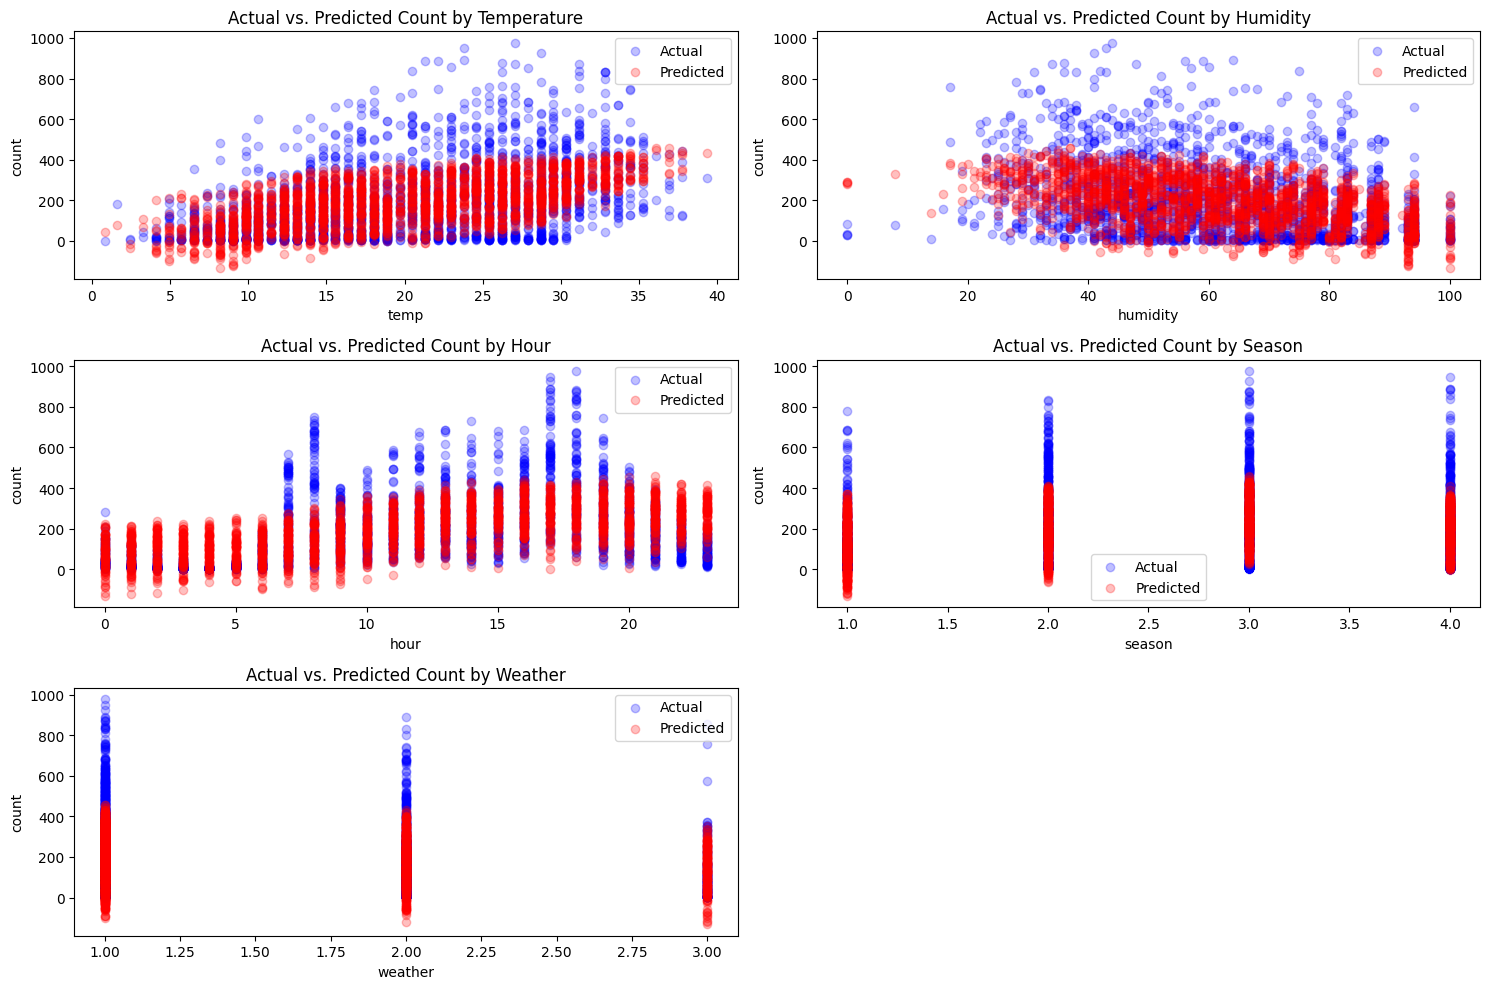

In [ ]:
plt.figure(figsize=(15, 10))

plt.subplot(321)
plt.scatter(X_test['temp'], y_test, alpha=0.25, c ='b', label='Actual')
plt.scatter(X_test['temp'], y_pred, alpha=0.25, c='r', label='Predicted')
plt.xlabel('temp')
plt.ylabel('count')
plt.title('Actual vs. Predicted Count by Temperature')
plt.legend()

plt.subplot(322)
plt.scatter(X_test['humidity'], y_test, alpha=0.25, c='b', label='Actual')
plt.scatter(X_test['humidity'], y_pred, alpha=0.25, c='r', label='Predicted')
plt.xlabel('humidity')
plt.ylabel('count')
plt.title('Actual vs. Predicted Count by Humidity')
plt.legend()

plt.subplot(323)
plt.scatter(X_test['hour'], y_test, alpha=0.25, c='b', label='Actual')
plt.scatter(X_test['hour'], y_pred, alpha=0.25, c='r', label='Predicted')
plt.xlabel('hour')
plt.ylabel('count')
plt.title('Actual vs. Predicted Count by Hour')
plt.legend()

plt.subplot(324)
plt.scatter(X_test['season'], y_test, alpha=0.25, c='b', label='Actual')
plt.scatter(X_test['season'], y_pred, alpha=0.25, c='r', label='Predicted')
plt.xlabel('season')
plt.ylabel('count')
plt.title('Actual vs. Predicted Count by Season')
plt.legend()

plt.subplot(325)
plt.scatter(X_test['weather'], y_test, alpha=0.25, c='b', label='Actual')
plt.scatter(X_test['weather'], y_pred, alpha=0.25, c='r', label='Predicted')
plt.xlabel('weather')
plt.ylabel('count')
plt.title('Actual vs. Predicted Count by Weather')
plt.legend()


plt.tight_layout()
plt.show()

### B. 변수 제거 피쳐 엔지니어링을 해봅시다!

In [ ]:
from sklearn.model_selection import train_test_split

# 다중공선성을 확인했으니, 적절한 변수 제거를 해봅시다.
X = train_df.drop(['count', 'casual','registered', 'datetime', 'atemp', 'humidity', 'min', 'sec'], axis=1)
y = train_df['count']


# 훈련 데이터와 테스트 데이터 분리
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

# 선형회귀 모델
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train,y_train)

y_pred = model.predict(X_test)

# MSE 및 RMSE 계산
from sklearn.metrics import mean_squared_error as mse
mse_error = mse(y_pred,y_test)
rmse_error = mse_error ** 0.5
print('mse error = ', mse_error)
print('rmse error = ', rmse_error)

mse error =  20908.756058943858
rmse error =  144.59860323994786


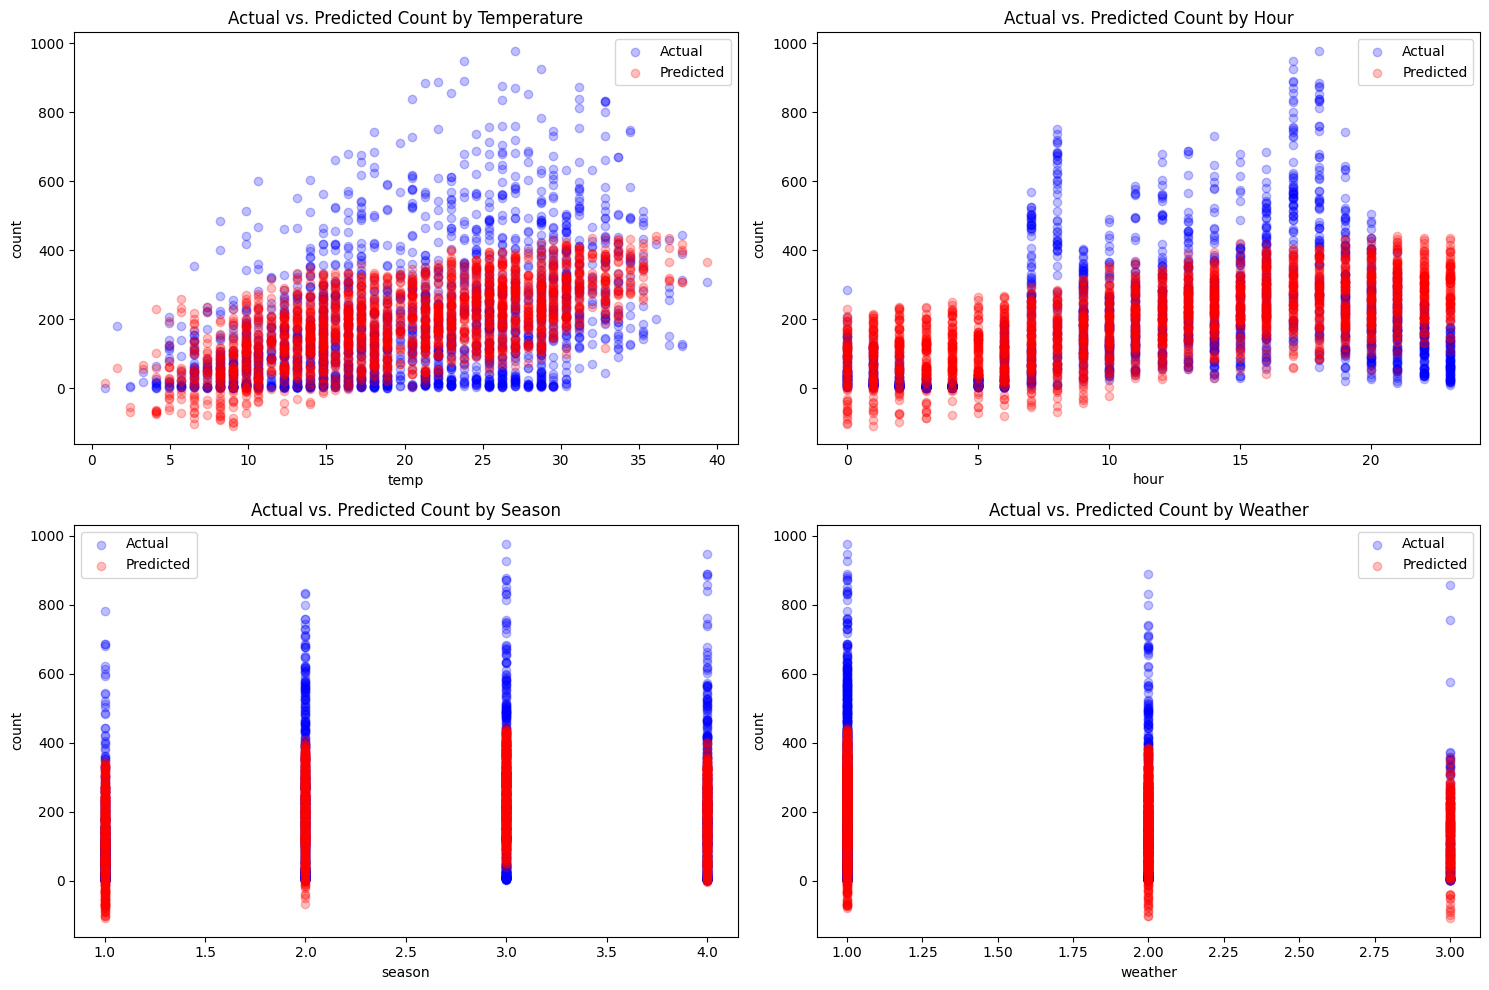

In [ ]:
plt.figure(figsize=(15, 10))

plt.subplot(221)
plt.scatter(X_test['temp'], y_test, alpha=0.25, c ='b', label='Actual')
plt.scatter(X_test['temp'], y_pred, alpha=0.25, c='r', label='Predicted')
plt.xlabel('temp')
plt.ylabel('count')
plt.title('Actual vs. Predicted Count by Temperature')
plt.legend()

plt.subplot(222)
plt.scatter(X_test['hour'], y_test, alpha=0.25, c='b', label='Actual')
plt.scatter(X_test['hour'], y_pred, alpha=0.25, c='r', label='Predicted')
plt.xlabel('hour')
plt.ylabel('count')
plt.title('Actual vs. Predicted Count by Hour')
plt.legend()

plt.subplot(223)
plt.scatter(X_test['season'], y_test, alpha=0.25, c='b', label='Actual')
plt.scatter(X_test['season'], y_pred, alpha=0.25, c='r', label='Predicted')
plt.xlabel('season')
plt.ylabel('count')
plt.title('Actual vs. Predicted Count by Season')
plt.legend()

plt.subplot(224)
plt.scatter(X_test['weather'], y_test, alpha=0.25, c='b', label='Actual')
plt.scatter(X_test['weather'], y_pred, alpha=0.25, c='r', label='Predicted')
plt.xlabel('weather')
plt.ylabel('count')
plt.title('Actual vs. Predicted Count by Weather')
plt.legend()


plt.tight_layout()
plt.show()

### C. PCA를 이용한 차원 축소를 해봅시다!

다중공선성이 높은 변수들을 제거하는 대신 PCA를 활용하여 차원 축소를 시도해 보겠습니다.

PCA는 분산을 최대한 보존하면서 데이터의 차원을 줄이는 기법입니다.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 아까 전처럼, 불필요한 열과 타겟변수와 역할이 겹치는 열들은 사전에 제거해줍니다
# 하지만 atemp와 humidity처럼 다중공선성이 강하게 나타나는 열들은 이번에 PCA를 통해서 처리해보도록 하죠!
X_pca = train_df.drop(['count', 'datetime', 'casual', 'registered', 'min', 'sec'], axis=1)
y_pca = train_df['count']

# PCA를 하기 위해 정규분포로의 표준화를 시도합니다. 분산의 단위를 같게 해줘야죠!
scaler = StandardScaler()
X_pca_scaled = scaler.fit_transform(X_pca)

pca = PCA()
X_pca_transformed = pca.fit_transform(X_pca_scaled)

# 주성분이 몇개나 될 지 판단해볼까요?
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained variance ratio by each component:")
print(explained_variance_ratio)

cumulative_explained_variance_ratio = explained_variance_ratio.cumsum()
print("\nCumulative explained variance ratio:")
print(cumulative_explained_variance_ratio)

Explained variance ratio by each component:
[0.21269475 0.15590114 0.10673303 0.10083549 0.08877638 0.08339073
 0.08156057 0.06839645 0.06209976 0.03610207 0.00232986 0.00117978]

Cumulative explained variance ratio:
[0.21269475 0.36859589 0.47532892 0.57616441 0.66494078 0.74833151
 0.82989208 0.89828853 0.96038829 0.99649036 0.99882022 1.        ]


In [ ]:
# 주성분이 몇개라고 생각하시나요?
# 저는 0.89 에서 끊어 8개의 주성분으로 시도해보겠습니다.
pca = PCA(n_components = 8)
X_pca_final = pca.fit_transform(X_pca_scaled)
X_pca_final = pd.DataFrame(X_pca_final)
X_pca_final.columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8']

In [ ]:
y = train_df['count']


# 훈련 데이터와 테스트 데이터 분리
X_train,X_test,y_train,y_test = train_test_split(X_pca_final,y,test_size=0.2,random_state=42)

# 선형회귀 모델
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train,y_train)

y_pred = model.predict(X_test)

# MSE 및 RMSE 계산
from sklearn.metrics import mean_squared_error as mse
mse_error = mse(y_pred,y_test)
rmse_error = mse_error ** 0.5
print('mse error = ', mse_error)
print('rmse error = ', rmse_error)

mse error =  19993.412985339528
rmse error =  141.3980657057922


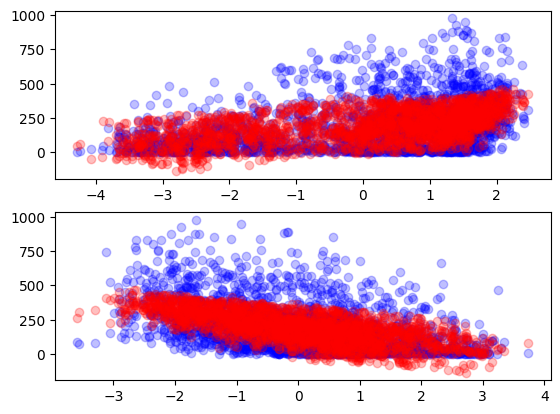

In [ ]:
X_pca_final.columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8']

plt.subplot(211)
plt.scatter(X_test['PC1'], y_test, alpha=0.25, c ='b', label='Actual')
plt.scatter(X_test['PC1'], y_pred, alpha=0.25, c='r', label='Predicted')

plt.subplot(212)
plt.scatter(X_test['PC2'], y_test, alpha=0.25, c ='b', label='Actual')
plt.scatter(X_test['PC2'], y_pred, alpha=0.25, c='r', label='Predicted')

### Q. 피쳐 엔지니어링의 결과는 어떤가요?

아마 생각 외로 오히려 성능이 나빠진 것을 확인할 수 있습니다!
이는 변수 제거로 인한 정보손실에서 오는 트레이드오프라고 할 수 있는데요,

해석 가능성을 확보하려고 하였으나 정보손실에서 오는 성능 손실은 피할 수 없는 일이기도 합니다.

# 아 참! 전처리 하는 거 까먹었다 ...

맞습니다 ㅠ 이상치에 대한 확인을 전혀 하지 않았네요!

데이터에 포함된 이상치는 모델 성능에 부정적인 영향을 줄 수 있습니다.

Boxplot을 그려서 각 변수별 이상치 분포를 확인하고, 필요에 따라 이상치를 처리하는 과정을 진행합니다.

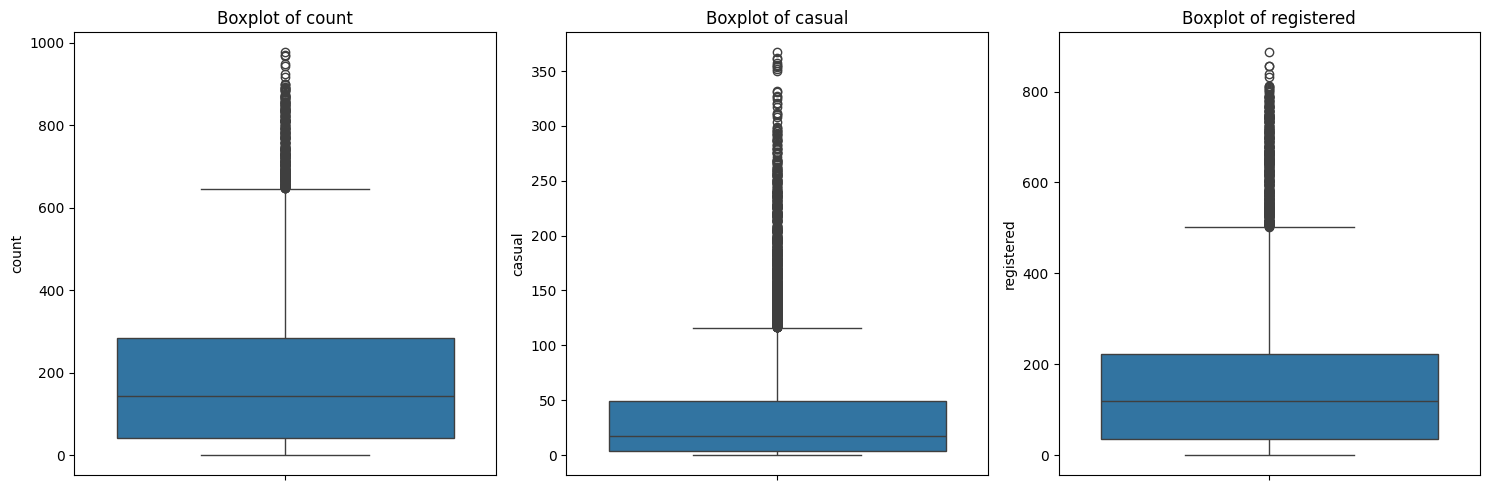

Original data shape: (10886, 18)
Cleaned data shape (after removing outliers in count): (10586, 18)


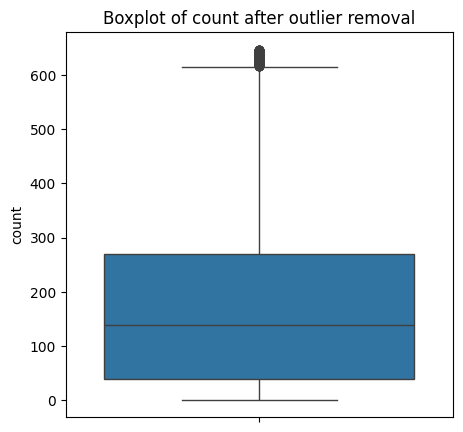

In [ ]:
# 이상치 확인을 위한 Boxplot 그리기
# count, casual, registered 열의 이상치를 확인합니다.
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(y=train_df['count'])
plt.title('Boxplot of count')

plt.subplot(1, 3, 2)
sns.boxplot(y=train_df['casual'])
plt.title('Boxplot of casual')

plt.subplot(1, 3, 3)
sns.boxplot(y=train_df['registered'])
plt.title('Boxplot of registered')

plt.tight_layout()
plt.show()

# 이상치 처리는 다양한 방법이 있습니다.
# 여기서는 count 열의 이상치를 제거하는 예시를 보여줍니다.
# IQR (Interquartile Range) 방법을 사용하여 이상치를 식별하고 제거할 수 있습니다.

Q1 = train_df['count'].quantile(0.25)
Q3 = train_df['count'].quantile(0.75)
IQR = Q3 - Q1

# 이상치 기준 설정 (예: 1.5 * IQR)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치 제거
train_df_cleaned = train_df[(train_df['count'] >= lower_bound) & (train_df['count'] <= upper_bound)].copy()

print(f"Original data shape: {train_df.shape}")
print(f"Cleaned data shape (after removing outliers in count): {train_df_cleaned.shape}")

# 이상치 처리 후 Boxplot 다시 그려서 확인
plt.figure(figsize=(5, 5))
sns.boxplot(y=train_df_cleaned['count'])
plt.title('Boxplot of count after outlier removal')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

# 다중공선성을 확인했으니, 적절한 변수 제거를 해봅시다.
X = train_df_cleaned.drop(['count', 'casual','registered', 'datetime', 'atemp', 'humidity', 'min', 'sec'], axis=1)
y = train_df_cleaned['count']


# 훈련 데이터와 테스트 데이터 분리
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

# 선형회귀 모델
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train,y_train)

y_pred = model.predict(X_test)

# MSE 및 RMSE 계산
from sklearn.metrics import mean_squared_error as mse
mse_error = mse(y_pred,y_test)
rmse_error = mse_error ** 0.5
print('mse error = ', mse_error)
print('rmse error = ', rmse_error)

mse error =  14683.76680582883
rmse error =  121.17659347344613


4분위로 기초적인 전처리를 하니 오차가 확 줄었습니다!

이처럼 데이터 전처리는 모델의 설정보다도 훨씬 더 중요한 기본 단계이니, 꼭 명심해주세요.


# 다른 회귀 모델 시도하기

scikit-learn에는 LinearRegression 말고도 다양한 회귀 모델이 있습니다.

여러 회귀 모델을 실행하는 함수를 작성하고, 어떤 모델이 좋은지 확인해볼까요?

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse, mean_squared_log_error as msle
import numpy as np

# Prepare data using the cleaned dataframe and dropping specified columns
X = train_df_cleaned.drop(['count', 'casual','registered', 'datetime', 'atemp', 'humidity', 'min', 'sec'], axis=1)
y = train_df_cleaned['count']

# 훈련 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def evaluate_model(model, X_train, X_test, y_train, y_test):
    """
    Trains a regression model, makes predictions, and evaluates performance using MSE, RMSE, and RMSLE.

    Args:
        model: The regression model to evaluate.
        X_train: Training features.
        X_test: Testing features.
        y_train: Training target.
        y_test: Testing target.

    Returns:
        A tuple containing the MSE, RMSE, and RMSLE of the model.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Ensure predictions are non-negative for RMSLE
    y_pred[y_pred < 0] = 0

    mse_error = mse(y_test, y_pred)
    rmse_error = mse_error ** 0.5

    # Calculate RMSLE, adding 1 to actual and predicted values
    msle_error = msle(y_test + 1, y_pred + 1)
    rmsle_error = msle_error ** 0.5

    return mse_error, rmse_error, rmsle_error

# Define a list of models to compare
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(random_state=42),
    "Lasso": Lasso(random_state=42),
    "Decision Tree Regressor": DecisionTreeRegressor(random_state=42),
    "Random Forest Regressor": RandomForestRegressor(random_state=42),
    "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=42)
}

results = {}

# Evaluate each model
for name, model in models.items():
    mse_error, rmse_error, rmsle_error = evaluate_model(model, X_train, X_test, y_train, y_test)
    results[name] = {"MSE": mse_error, "RMSE": rmse_error, "RMSLE": rmsle_error}
    print(f"{name}: MSE = {mse_error:.2f}, RMSE = {rmse_error:.2f}, RMSLE = {rmsle_error:.4f}")

# Optional: Display results in a DataFrame for easier comparison
results_df = pd.DataFrame(results).T
print("\nModel Performance Comparison:")
display(results_df)

Linear Regression: MSE = 14607.36, RMSE = 120.86, RMSLE = 1.1762
Ridge: MSE = 14607.24, RMSE = 120.86, RMSLE = 1.1762
Lasso: MSE = 14587.66, RMSE = 120.78, RMSLE = 1.1710
Decision Tree Regressor: MSE = 3344.37, RMSE = 57.83, RMSLE = 0.4196
Random Forest Regressor: MSE = 1730.82, RMSE = 41.60, RMSLE = 0.3247
Gradient Boosting Regressor: MSE = 4067.09, RMSE = 63.77, RMSLE = 0.6550

Model Performance Comparison:


,MSE,RMSE,RMSLE
Linear Regression,14607.357852,120.860903,1.176186
Ridge,14607.236626,120.860401,1.176151
Lasso,14587.664362,120.779404,1.171048
Decision Tree Regressor,3344.373938,57.830562,0.419618
Random Forest Regressor,1730.822898,41.603160,0.324697
Gradient Boosting Regressor,4067.093747,63.773770,0.654954


### 모델마다 엄청난 차이가 보입니다! 왜 그럴까요?

이는 모델이 가지고 있는 Inductive Bias, 귀납적 편향이 다르기 때문입니다!

모델의 귀납적 편향을 조사하고, 왜 이런 차이가 생겼을 지 탐구해보세요!

# 결론 !

1일차 실습을 통해 우리는 다음과 같은 중요한 머신러닝 워크플로우를 경험했습니다.

1. 데이터 로드 및 전처리: 데이터를 학습 가능한 형태로 변형하고, 이상치를 감지하고 제거하는 작업을 진행했습니다.
2. 다양한 회귀모델 적용: 주어진 데이터에 대해서 여러 회귀 모델을 사용했고, 성능의 편차가 존재한다는 것을 실험적으로 확인했습니다.

위 데이터는 다음 2일차에서도 다시 활용됩니다.

2일차에서는,

1. 신뢰성 있는 평가: 교차 검증과 RMSLE 지표로 모델을 객관적으로 평가하고,
2. 성능 극대화: Grid Search로 하이퍼파라미터를 튜닝하여 주어진 모델의 사전설정을 바꾸어 성능을 극대화하는 방법을 살피고
3. 결과에 대한 설명: 여러 지표를 활용해 단순히 "이 모델이 좋다"를 넘어 "왜 좋은지"를 설명합니다.

고생하셨습니다!